Klassifikation des Genres von Songs anhand ihrere Texte (Pascal Niedermeyer, Philipp Tull, Simon Triem)
Ziel dieses Projektes ist es zu Prüfen ob es möglich ist das Genre eines Songs anhand des Textes korrekt vorherzusagen. Dabei werden unterschiedliche Modelle aus den Bereichen Machien Learning sowie Neuronalenetze verwendet.
Dabei wird nicht nur evaluiert ob und wie gut die verscheidenen Modelle des Genre vorhersagen, sondern auch wie gut die Modelle untereinander abschneiden.
Da oftmals nicht nur ein Vergleich zwischen verschiedenen Modellen interresant ist, sondern auch der Vergleich zwischen Mensch und Maschiene interresante Ergebnisse liefert, Testen wir die Textklassifikation auch an verschiedenen Probanten. Diese Ergebnisse werden am Ende des Dokumentes vorgestellt. 

Die in diesem Projekt verwendeten Daten stammen von https://www.kaggle.com/.

Dieses Projekt trainiert ein Modell, um das Genre eines Songs anhand des Song-Textes vorherzusagen.
Dafür verwenden wir Daten von kaggle und beschränken uns auf englische Songlyrics der Genres Rock, Pop und Hip-Hop.

Im ersten Codeblock filtern wir die Rohdaten (wie in den Kommentaren beschrieben):

Bevor wir mit der Beschreibung der verschiedenen Modellen beginnen müssen zuvor noch ein paar Anpassungen der Daten vorgenommen werden. 
Da es sich bei den zuvor erwähnten Daten von Kaggle um eine riesige Menge an Information handelt und ein Großteil dieser Information für unser Projekt irrelevant ist, müssen wir zuerst die Daten etwas berreinigen, verkleinern und anpassen.
In unseren Vorhersagemodellen abreiten wir nur mit englischen Texten. Daher werden alle anderen Textsprachen im weiteren Verlauf nicht mehr betrachtet. Des Weiteren werden alle Wörter die in unseren Daten groß geschrieben sind, in kleingeschirebene Wörter transformiert.
Auch befinden sich in den Lyrics keine Texte an sich sondern Instrumentals oder andere Zeichenfolgen, mit denen unsere Modelle nichts anfangen können. Daher werden auch diese Texte im Weiteren nicht betrachtet.
In unseren Daten gibt es sechs verschiedene Genre. (Rock, Pop, Hip Hop, Samba, Sertanejo und Funk Carioca). Allerdings sind Samba, Sertanejo und Funk Cariocanur nur sehr sher wenig vertreten. Deshalb fließen diese Genre nicht in unsere bewertung mit ein, da durch die wenigen Daten kein vernüftiges Ergebnis entstehen würde.

In [1]:
import pandas as pd


pathLyrics = "./song-lyrics/lyrics-data.csv"
pathArtists = "./song-lyrics/artists-data.csv"

dataframeLyrics = pd.read_csv(pathLyrics)
dataframeArtists = pd.read_csv(pathArtists)

#Nur englische Lyrics, Lowercase für Artists + Lyrics
dataLyricsFilterd = dataframeLyrics[dataframeLyrics['Idiom'] == 'ENGLISH']
dataLyricsFilterd = dataLyricsFilterd.apply(lambda x: x.astype(str).str.lower())
dataArtistsFilterd = dataframeArtists.apply(lambda x: x.astype(str).str.lower())

#Lösche Irrelevante Attribute der Artists
del dataArtistsFilterd['Genres']
del dataArtistsFilterd['Popularity']
del dataArtistsFilterd['Songs']


#print(first)
#print(dataLyricsFilterd)

#Unsere Datenanalyse ergab, dass es 3 irrelevante Genres mit sehr wenig Daten gibt.
#Da diese Genres nicht aussagekräfitg sind werden sie im weiterem Verlauf nicht betrachtet.
dataArtistsFilterd = dataArtistsFilterd[dataArtistsFilterd['Genre'] != 'samba']
dataArtistsFilterd = dataArtistsFilterd[dataArtistsFilterd['Genre'] != 'sertanejo']
dataArtistsFilterd = dataArtistsFilterd[dataArtistsFilterd['Genre'] != 'funk carioca']

#Doppelte Artists ignorieren -> erster Artist wird jeweils genommen
sorted = dataArtistsFilterd.sort_values(['Link'])

dataArtistsFilterd = sorted.groupby('Link').first().reset_index()

i = dataArtistsFilterd

#Kleinere Datenmenge!! Zum Debuggen. Um das zu aktivieren Zeile 53 auskommentieren!
test = i[i['Artist'] == '10000 maniacs' ]
#print(test)
test2 = i[i['Artist'] == 'will.i.am' ]
test3 = i[i['Artist'] == 'jennifer lopez' ]

test = test.append(test2)
test = test.append(test3)
#In den Lyrics befinden sich einige "schmutzigen" Lyrics, bspw. Instrumentals oder Chord-Sheets. 
# Da diese irrelevant sind und unser Ergebnis negativ beeinflussen würden betrachten wir diese ebenfalls nicht.
# => Die Chordsheets haben Pattern wie "---" oder "===", Instrumentale Songs "instrumental"
patternDel = ["---", "instrumental","==="]
for patt in patternDel:
    filter = dataLyricsFilterd['Lyric'].str.contains(patt)
    dataLyricsFilterd = dataLyricsFilterd[~filter]
    
#dataArtistsFilterd = test
#dataLyricsFilterd.to_csv('filterdData.csv')

FileNotFoundError: [Errno 2] File b'./song-lyrics/lyrics-data.csv' does not exist: b'./song-lyrics/lyrics-data.csv'

Unsere zur Verfügung gestellen Daten zu Genre und Texten befinden sich in zwei Tabellen. Eine Song-Tabelle und eine Artists-Tabelle. In der Artists-Tabelle befinden sich unteranderem der Artist, der Songname, sowie das dazugehörige Genre. In der Song-Tablle befindet sich der Text und ein Verweis auf den entsprechenden Song aus der Artist-Tabelle.
Um nun mit diesen Daten arbeiten zu können, fusionieren wir die beiden Tabllen zu einer einzzelnen Tabelle. 
Informationen die im Weiteren Verlauf des Projektes nicht benötigt werden, werden auch hier entfernt, um die Datenmenge möglichst klein zu halten.
Ein Ausschnitt der beiden Tabbelen und der fusionierten Tabelle befindet sich unterhalb dieses Codeblocks.  

In [2]:
#print(dataArtistsFilterd)
#Die beiden Tabellen der Artists und Lyrics werden im folgenden Zusammengeführt:
mergedData = pd.merge(dataLyricsFilterd, dataArtistsFilterd, how='inner', left_on='ALink',right_on='Link')
#print(mergedData)

#Unnötige irrelevante Attribute werden wieder entfernt:
del mergedData['ALink']
del mergedData['SName']
del mergedData['SLink']
del mergedData['Idiom']
del mergedData['Artist']
del mergedData['Link']
#mergedData
#mergedData.to_csv('mergedData.csv')

                  Link          Artist    Genre
1      /10000-maniacs/   10000 maniacs     rock
1940       /will-i-am/       will.i.am  hip hop
824   /jennifer-lopez/  jennifer lopez      pop


In diesem Teil sehen wir die gaphische Verteilung unserer Daten anhand ihrer Genre.

<AxesSubplot:>

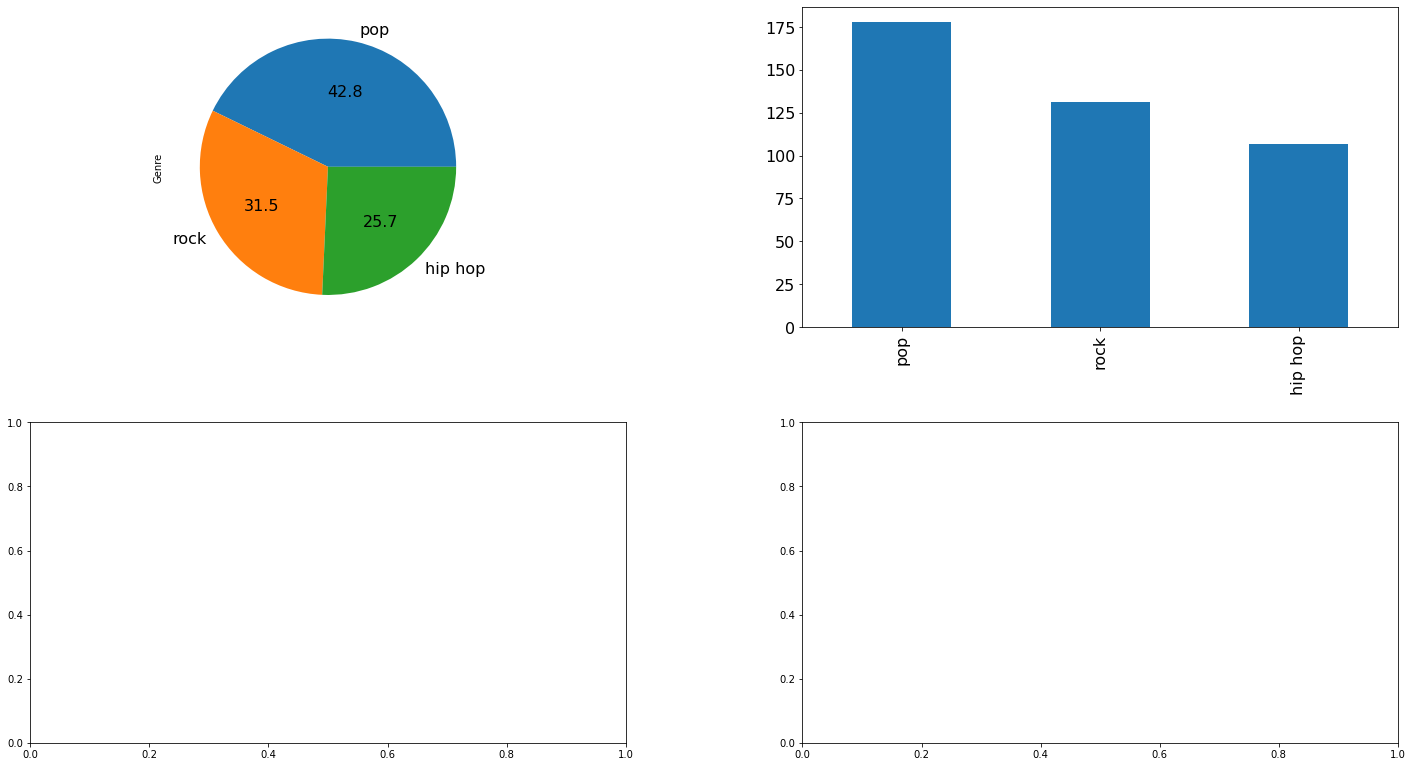

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt


genreCount = mergedData['Genre'].value_counts()

fig, axarr = plt.subplots(2, 2)
fig.tight_layout()


genreCount.plot.pie( figsize=(12, 12), fontsize=16, ax=axarr[0][0] , autopct='%.1f' )
genreCount.plot.bar( figsize=(22, 12), fontsize=16, ax=axarr[0][1] )



Anhand dieser Datenanalyse mit den gefilterten Daten sehen wir, dass die Genres ungefähr gleich verteilt sind, was eine Vorhersage leichter machen kann. 

Im Folgenden werden Stoppwörter sowie irrelevante Zeichen aus den Lyrics durch Leerzeichen ersetzt. Des Weiteren möchten wir für unserer Vorhersage nur bestimmte Wörter verwenden. Hierzu betrachten wir nur die 10000 häufigsten Wörter, bzw die 10100 häufigsten wörter ohne die 100 häufigsten Wörter. Der Grund hierfür liegt darin, dass Wörter die nicht unter den 10100 häufigsten Wörten sind, so selten vorkommen das sie in unserer Vorhersage kaum bis keinen Einfluss haben, da sie zu selten vorhanden sind. Aber auch die 100 häufigsten wörter werden außen vor gelassen, weil diese Wörter praktisch fast in jedem Songtext vorhanden sind und somit auch kaum bis keine Auswirkungen auf unsere Vorhersage hätten. Anders gesagt wir würden Daten betrachten die für unser Ergebnis sogut wie irrelevant wären.

In [14]:
from collections import Counter 

#Irrelevante Zeichen und Stoppwörter
replacement = {',','.','(',')','[chorus:]','-','/','?','!','[','&',']','"'}

for index, lyric in enumerate(mergedData["Lyric"]):
    for repl in replacement:
        #Ersetze Wörter durch Leerzeichen:
        mergedData["Lyric"][index] = mergedData["Lyric"][index].replace(repl, ' ')

#Word Index mit den meisten 10.100:
word_index = Counter(" ".join(mergedData["Lyric"]).split()).most_common(10100)
#Lösche 100 häufigste Wörter raus
word_index = word_index[100:]
#print(word_index)

[('been', 225), ('some', 221), ('too', 218), ('night', 217), ('more', 217), ('gotta', 217), ('life', 212), ('about', 211), ('body', 206), ('who', 202), ('away', 202), ('tell', 201), ('had', 201), ('by', 198), ("'cause", 198), ('long', 197), ('still', 194), ('put', 193), ('look', 193), ('am', 192), ("i'll", 192), ('around', 191), ('booty', 191), ('tonight', 187), ('play', 182), ('day', 181), ('why', 179), ('our', 176), ('hey', 176), ('eyes', 174), ('would', 173), ('gonna', 173), ('party', 173), ('mama', 172), ('them', 171), ('rock', 169), ('move', 169), ('were', 168), ('off', 168), ('dance', 164), ('boy', 164), ('call', 163), ('into', 161), ('hands', 155), ('man', 153), ('thing', 152), ('little', 147), ('shake', 143), ('mind', 136), ('chorus', 134), ('keep', 133), ('girls', 133), ('floor', 132), ('even', 131), ('rocking', 131), ('money', 130), ('again', 127), ('live', 126), ('his', 125), ('then', 125), ('heart', 125), ('only', 124), ('better', 124), ("we're", 123), ('through', 123), ('r

Die oben errechnete Häufigkeitsanalyse wird im Folgenden auf die bereits gefilteren Lyric-Daten angewendet. Hierzu betrachten wir nur relevanten Wörter pro Songtext und zählen diese.
Die Daten werden dann entsprechend in boolean-Arrays "konvertiert", damit wir ein Modell darauf trainieren können.
Die 3 betrachteten Genre werden One-Hot-Encoded (Rock: 100, Pop: 010, Hip-Hop: 001):

In [15]:
#most_common = set([t[0] for t in word_index]) 
most_common = []
for t in word_index:
    most_common.append(t[0])
    
#print(len(most_common))    
#print(most_common)
xdata = []
xdata_boolean = []
ydata = []
ydata_integer = []
xdata_count = []
for lyric in mergedData['Lyric']:
    lyric_words_count = []
    cleared_lyrics_boolean = []
    for words in most_common:
        count = lyric.count(" "+words+" ")
        lyric_words_count.append(count)
        if count != 0:
            cleared_lyrics_boolean.append(1)
        else:
            cleared_lyrics_boolean.append(0)
    xdata_count.append(lyric_words_count)
    xdata_boolean.append(cleared_lyrics_boolean)
#print(xdata_count[0])    

#One Hot Encoding für das Genre:
for genre in mergedData['Genre']:
    if genre == "rock": 
        ydata_integer.append([1,0,0]);
        ydata.append(0);
    
    elif genre == "pop": 
        ydata_integer.append([0,1,0]);
        ydata.append(1);
     
    elif genre == "hip hop": 
        ydata_integer.append([0,0,1]);
        ydata.append(2);

#print (ydata_integer)

    #ydata.append(genre)
    

6989


Nachdem die Daten gefiltert und entsprechend encoded wurden, können wir mit unseren eigentlichen Modellen zur Vorhersage der Genre anhand von Songtexten beginnen.
Für die Klassifikation anahnd eines Neuronalen Netzes verwenden wir das Feed-Farward Modell.
Hierzu werden unsere Daten in Tainigs-/ und Testdaten aufgeteilt. (0.8, 0.2) Um unser Ergebnis zu evaluieren nutzen wir 20% der Trainingsdaten als Validationsdaten.
Das ergebnis wird unterhalb des Codeblocks dargestellt.

In [19]:
import numpy as np
from keras import models
from keras import layers
import keras as keras

from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(xdata_count,ydata_integer, test_size=0.2)

#print(test_data)

X_train = np.asarray(train_data).astype('float32')
X_test = np.asarray(test_data).astype('float32')

#print(test_labels)
#print(X_train)
#print(train_data)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

#print(X_train)

model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(6989,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='sigmoid'))
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
#print(model.get_weights())
history = model.fit(X_train, y_train, epochs=100, batch_size=100, validation_split=0.2)

# compute loss and accuracy on test data
score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 128)               894720    
_________________________________________________________________
dense_26 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_27 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_28 (Dense)             (None, 3)                 99        
Total params: 905,155
Trainable params: 905,155
Non-trainable params: 0
_________________________________________________________________
Train on 265 samples, validate on 67 samples
Epoch 1/100
265/265 [==============================] - 0s 1ms/step - loss: 0.7186 - accuracy: 0.4516 - val_loss: 0.6922 - val_accuracy: 0.5025
Epoch 2/100
265/265 [==============================] - 0s 

Epoch 51/100
265/265 [==============================] - 0s 291us/step - loss: 0.5150 - accuracy: 0.8679 - val_loss: 0.5799 - val_accuracy: 0.7114
Epoch 52/100
265/265 [==============================] - 0s 290us/step - loss: 0.5117 - accuracy: 0.8692 - val_loss: 0.5778 - val_accuracy: 0.7114
Epoch 53/100
265/265 [==============================] - 0s 317us/step - loss: 0.5084 - accuracy: 0.8692 - val_loss: 0.5757 - val_accuracy: 0.7114
Epoch 54/100
265/265 [==============================] - 0s 290us/step - loss: 0.5051 - accuracy: 0.8692 - val_loss: 0.5736 - val_accuracy: 0.7114
Epoch 55/100
265/265 [==============================] - 0s 317us/step - loss: 0.5018 - accuracy: 0.8704 - val_loss: 0.5716 - val_accuracy: 0.7114
Epoch 56/100
265/265 [==============================] - 0s 298us/step - loss: 0.4985 - accuracy: 0.8704 - val_loss: 0.5695 - val_accuracy: 0.7114
Epoch 57/100
265/265 [==============================] - 0s 306us/step - loss: 0.4952 - accuracy: 0.8730 - val_loss: 0.5674 -

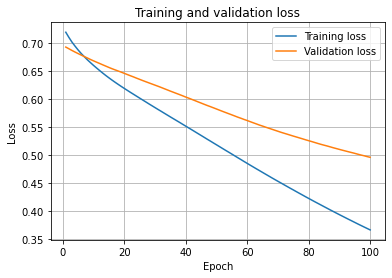

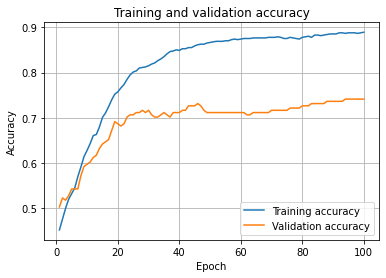

In [20]:
#Analyse deAccuracy/Loss:

history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

history_dict = history.history
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation accuracy')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Um unser Neuronales Netzt vergleichen zu können, nutzen wir einen herkömmlichen Naive-Bayse Klassifikation aus dem Bereich des Machine Learning. Dieser Arbeitet auch mit 80% Trainigs-/ und 20% Testdaten.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

train_data, test_data, train_labels, test_labels = train_test_split(xdata_boolean,ydata, test_size=0.2)


X_train = np.asarray(train_data).astype('float32')
X_test = np.asarray(test_data).astype('float32')

#print(test_labels)

#print(X_train)
#print(train_data)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')






## Naive Bayes mit additiver Glättung trainieren
nb = MultinomialNB(alpha=1.0)
nb.fit(X_train, y_train)

## Vorhersagen berechnen
y_predicted = nb.predict(X_test)

## Konfusionsmatrix ausgeben
print("Kofusionsmatrix:\n", confusion_matrix(y_true=y_test, y_pred=y_predicted))

## Gütemaße ausgeben
print("Korrektklassifizierungsrate:\n", accuracy_score(y_true=y_test, y_pred=y_predicted))
print("Präzision (mikro):\n", precision_score(y_true=y_test, y_pred=y_predicted, average='micro'))
print("Ausbeute (mikro):\n", recall_score(y_true=y_test, y_pred=y_predicted, average='micro'))
print("F1 (mikro):\n", f1_score(y_true=y_test, y_pred=y_predicted, average='micro'))

Kofusionsmatrix:
 [[16  5  0]
 [ 0 37  0]
 [ 0 11 15]]
Korrektklassifizierungsrate:
 0.8095238095238095
Präzision (mikro):
 0.8095238095238095
Ausbeute (mikro):
 0.8095238095238095
F1 (mikro):
 0.8095238095238095


Wir können sehen, dass der Naive Bayes Klassifikator im Vergleich zum Feed Forward Netz _ ist.
Eine weitere Evaluation führen wir durch, indem wir reale Personen Lyrics einem der 3 Genres zuordnen lassen. 
Hierfür haben wir 5 Songtexte pro Genre zufällig aus dem Datensatz gewählt und unsere Testpersonen entscheiden lassen,
zu welchem Genre sie den gegebenen Songtext am ehesten zuodrnen würden. 
Von _ befragten Probanden 
X aus 15 Richtig









dadurch ergibt sich, dass die Trefferquote insgesamt X aus X beträgt, was eine Accurcy von X ergibt.
Damit sind reale Personen im Vergleich zu unserem Ansatz _.
Link zur Umfrage: ___


In [24]:
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Embedding
from keras.layers import Flatten
from keras.preprocessing import sequence
# number of most frequent words to consider
num_words = 1000
# maximum length of lyrics (only the first so many words are considered)
max_len = 6989
# embedding dimensionality
emb_dim = 32
# describe model architecture
model = Sequential()
model.add(Embedding(num_words, emb_dim, input_length=max_len))
model.add(SimpleRNN(32, recurrent_dropout=0.2, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)
# compute loss and accuracy on test data
score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

C:\Users\simon\anaconda3\envs\myenv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 265 samples, validate on 67 samples
Epoch 1/10


KeyboardInterrupt: 